<a href="https://colab.research.google.com/github/visionNoob/detectron2_aihub_tutorial/blob/master/Detectron2_training_custom_dataset_(AIHub_sidewalk_datataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. DATASET 구성
데이터셋을 다음과 같이 구성하세요. 

다운로드  
[aihub_27_classes_label.csv](https://www.dropbox.com/s/mh3yeeu22h8spqb/aihub_27_classes_label.csv
)  
[aihub_13_classes_label.csv](https://www.dropbox.com/s/byecey0zebrn203/aihub_13_classes_label.csv
)

```
${DATASET_ROOT}
 `-- aihub_27_classes_label.csv
  -- aihub_13_classes_label.csv
  -- images`
     |-- 0617_01
     |   |-- 0617_01.xml
     |   |-- MP_SEL_000001.jpg
     |   |-- MP_SEL_000002.jpg
     |   |-- MP_SEL_000003.jpg
     |   |-- MP_SEL_000004.jpg
     |   |-- ...
     |-- 0617_02
     |   |-- 0617_02.xml
     |   |-- MP_SEL_000201.jpg
     |   |-- MP_SEL_000202.jpg
     |   |-- MP_SEL_000203.jpg
     |   |-- MP_SEL_000204.jpg
     |   |-- ...
     |-- 0617_04
     |   |-- 0617_03.xml
     |   |-- MP_SEL_000601.jpg
     |   |-- MP_SEL_000602.jpg
     |   |-- MP_SEL_000603.jpg
     |   |-- MP_SEL_000604.jpg
     |   |-- ...
```

In [0]:
# 기본 설정
import os
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import csv
import torch, torchvision
import numpy as np
import cv2
import json
import itertools
from glob import glob
import xml.etree.ElementTree as elemTree

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

print(torch.__version__)

1.3.0


In [0]:
DATASET_ROOT = ${DATASET_ROOT} # 데이터셋이 속한 디렉토리 경로를 추가하세요 
# e.g. DATASET_ROOT = '/home/visionnoob/dataset/aihub'

# 2. 레이블 파일 불러오기 

In [0]:
def get_label_list(label_path):
    
    labels = []

    with open(label_path) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            labels.append(row[0])
    return labels

label_path = os.path.join(DATASET_ROOT, "aihub_27_classes_label.csv")
print(labels)

['wheelchair', 'truck', 'tree_trunk', 'traffic_sign', 'traffic_light', 'table', 'stroller', 'stop', 'scooter', 'potted_plant', 'pole', 'person', 'parking_meter', 'movable_signage', 'motorcycle', 'kiosk', 'fire_hydrant', 'dog', 'chair', 'cat', 'carrier', 'car', 'bus', 'bollard', 'bicycle', 'bench', 'barricade']


# 3. get_crosswalk_dicts 함수 작성
Detectron2에 Dataset 등록을 위해 필요한 함수를 작성합니다.  
본 예제에서는 간단히 training dataset을 구성하였습니다.  
같은 방법으로 validation dataset을 구성하여 학습에 이용할 수 있습니다. 

In [0]:
def get_crosswalk_dicts():
    
    label_path = os.path.join(DATASET_ROOT, "aihub_27_classes_label.csv")
    image_path = os.path.join(DATASET_ROOT, 'images')
    
    dirs = glob(os.path.join(image_path,'*'))
    xmls = glob(os.path.join(image_path,'*/*.xml'))
    
    labels = get_label_list(label_path)
    dataset_dicts = []
    #for xml in xmls:
    for sub_dir in dirs:

        xml_path = os.path.join(sub_dir,glob(os.path.join(sub_dir,"*.xml"))[0])
        images_path = glob(os.path.join(sub_dir,"*.jpg"))
        tree = elemTree.parse(xml_path)
        for image in tree.findall('./image'):
            
            jpg_name = os.path.join(sub_dir,image.attrib['name'])
            if not jpg_name in images_path:
                print("pass because no image -> {}".format(jpg_name))
                continue
            
            record = {}
            record["file_name"] = jpg_name
            record["height"] = int(image.attrib['height'])
            record["width"] = int(image.attrib['width'])
        
            objs = []
            for box in image.findall('./box'):
                obj = {
                    "bbox": [
                        float(box.attrib['xtl']), 
                        float(box.attrib['ytl']), 
                        float(box.attrib['xbr']), 
                        float(box.attrib['ybr'])],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": labels.index(box.attrib['label']),
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts
 

# 4. 데이터셋 등록   

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("crosswalk/train", get_crosswalk_dicts)
MetadataCatalog.get("crosswalk/train").set(thing_classes=labels)
crosswalk_metadata = MetadataCatalog.get("crosswalk/train")

pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051001.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051002.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051003.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051004.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051005.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051006.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051007.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051008.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051010.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051015.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051017.jpg
pass because no image

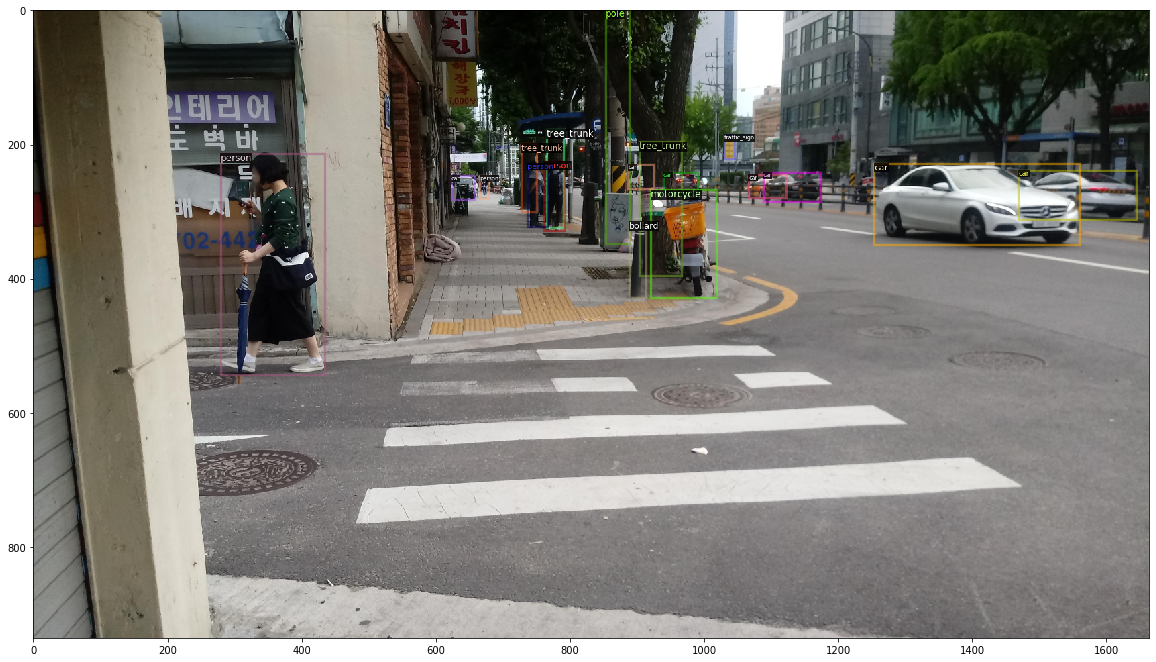

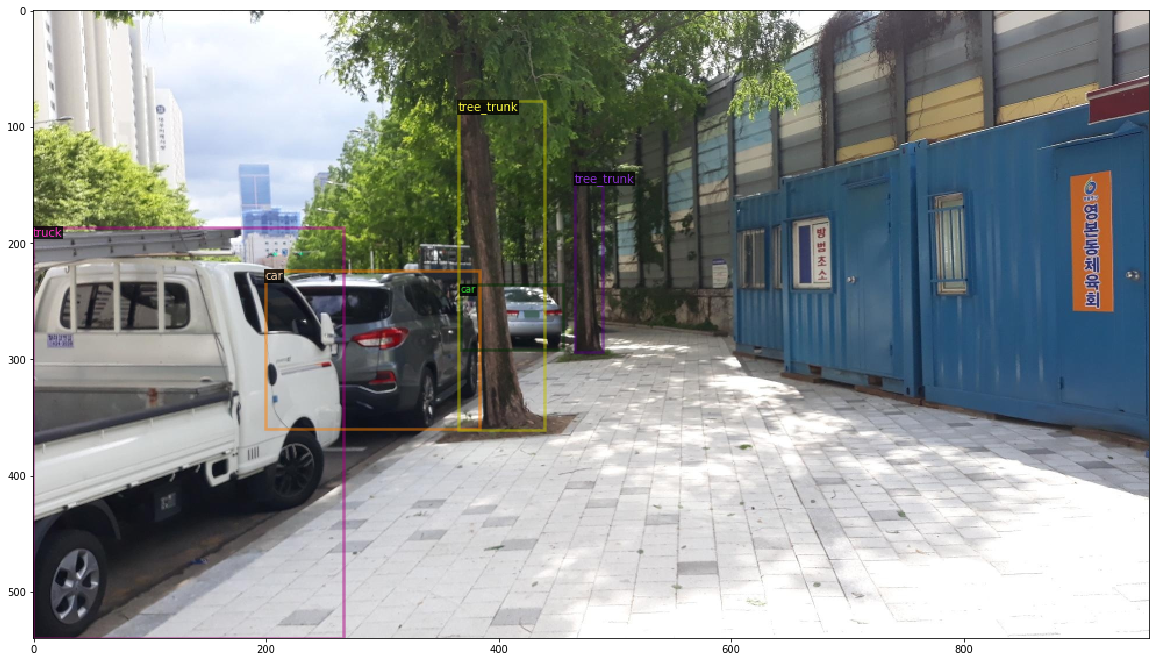

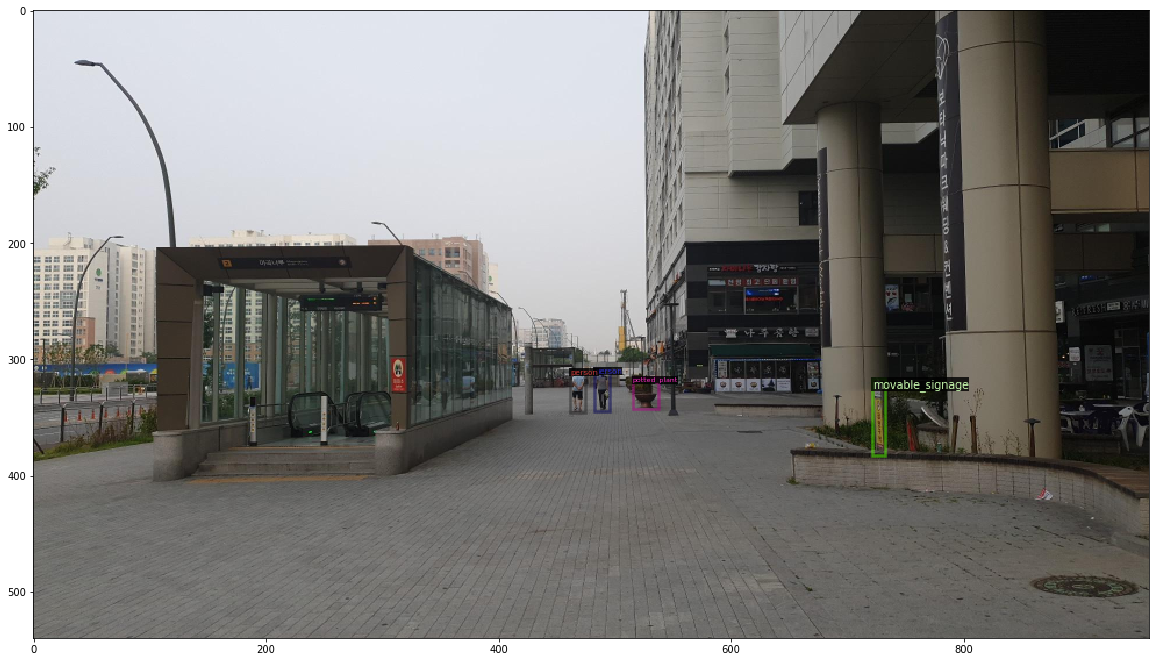

In [0]:
# 잘 등록되었나 확인 
import random
import matplotlib.pyplot as plt
%matplotlib inline

def cv2_imshow(image):
    plt.figure(figsize=(20,20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
dataset_dicts = get_crosswalk_dicts()
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=crosswalk_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# 5. RetinaNet 학습하기

In [0]:
#os.chdir("/home/visionnoob/git_project/detectron2")

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("crosswalk/train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 6
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5000000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27  # only has one class (ballon)

Loading config ./configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


WARNING [12/23 00:13:41 d2.config.compat]: Config './configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[12/23 00:13:41 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051001.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051002.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051003.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051004.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051005.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051006.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051007.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051008.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051010.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051015.jpg
pass because no image -> /home/visionnoob/dataset/aihub/images/0712_21/MP_SEL_051017.jpg
pass because no image

KeyboardInterrupt: 